In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36875/status,
Dashboard: /proxy/36875/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41475,Workers: 4
Dashboard: /proxy/36875/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:36541,Total threads: 4
Dashboard: /proxy/37733/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39899,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [13]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask_lowres.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [14]:
dx = np.pi/180*6371e3*np.cos(np.deg2rad(uas['erai']['lat']))
dy = np.pi/180*6371e3

area = np.zeros(np.shape(uas['erai'].isel(time = 0)))
for i in range(len(uas['erai']['lat'])):
    area[i, :] = dx.isel(lat = i)*dy

area = xr.DataArray(area, dims = ['lat', 'lon'], coords = {'lat':uas['erai']['lat'], 'lon':uas['erai']['lon']})

In [4]:
uas = {}
vas = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
uas_DJF = {}
vas_DJF = {}
for k in keys:
    uas_DJF[k] = uas[k].where(uas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()
    vas_DJF[k] = vas[k].where(vas[k].time.dt.season == "DJF", drop = True).isel(time = slice(2,-1)).coarsen(time = 3).mean()

In [6]:
uas_MAM = {}
vas_MAM = {}
for k in keys:
    uas_MAM[k] = uas[k].where(uas[k].time.dt.season == "MAM", drop = True).coarsen(time = 3).mean()
    vas_MAM[k] = vas[k].where(vas[k].time.dt.season == "MAM", drop = True).coarsen(time = 3).mean()

In [7]:
uas_JJA = {}
vas_JJA = {}
for k in keys:
    uas_JJA[k] = uas[k].where(uas[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()
    vas_JJA[k] = vas[k].where(vas[k].time.dt.season == "JJA", drop = True).coarsen(time = 3).mean()

In [8]:
uas_SON = {}
vas_SON = {}
for k in keys:
    uas_SON[k] = uas[k].where(uas[k].time.dt.season == "SON", drop = True).coarsen(time = 3).mean()
    vas_SON[k] = vas[k].where(vas[k].time.dt.season == "SON", drop = True).coarsen(time = 3).mean()

In [20]:
u_ave_DJF = {}; v_ave_DJF = {}
u_ave_MAM = {}; v_ave_MAM = {}
u_ave_JJA = {}; v_ave_JJA = {}
u_ave_SON = {}; v_ave_SON = {}
for k in keys:
    u_ave_DJF[k] = (uas_DJF[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_DJF[k] = (vas_DJF[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
    u_ave_MAM[k] = (uas_MAM[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_MAM[k] = (vas_MAM[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
    u_ave_JJA[k] = (uas_JJA[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_JJA[k] = (vas_JJA[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    
    u_ave_SON[k] = (uas_SON[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))
    v_ave_SON[k] = (vas_SON[k]*mask*area).sum('lat').sum('lon')/((area*mask).sum('lat').sum('lon'))

In [22]:
from matplotlib.lines import Line2D

In [23]:
legend_elements = [Line2D([0], [0], color = 'k', lw = 3, label = 'CMIP6 MMM'),
                   Line2D([0], [0], color = 'm', lw = 2, label = 'Multireanalysis mean'),
                   Line2D([0], [0], color = cmocean.cm.rain(.3), lw = 1.2, label = 'ERA-Interim'),
                   Line2D([0], [0], color = cmocean.cm.rain(.45), lw = 1.2, label = 'ERA5'),
                   Line2D([0], [0], color = cmocean.cm.rain(.62), lw = 1.2, label = 'CFSR'),
                   Line2D([0], [0], color = cmocean.cm.rain(.76), lw = 1.2, label = 'JRA55')]

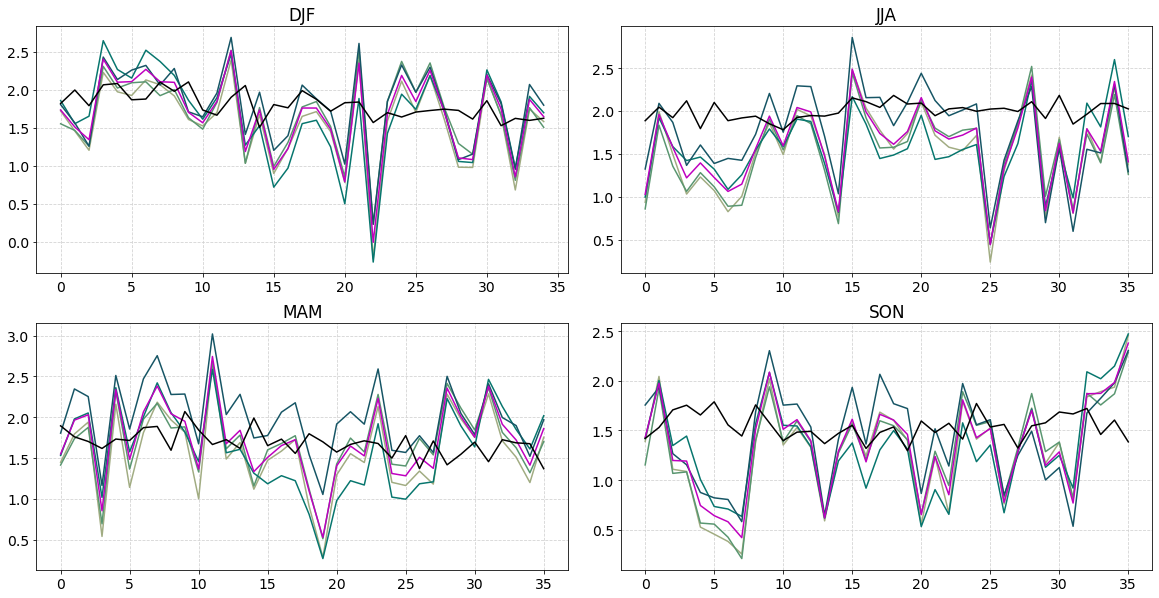

In [33]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, wspace = 0.1)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax in axs:
    ax.grid(linestyle = '--', color = 'lightgrey')
axs[0].set_title('DJF')
axs[1].set_title('MAM')
axs[2].set_title('JJA')
axs[3].set_title('SON')
for k, clr in zip(keys, [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm', 'k']):
    axs[0].plot(-u_ave_DJF[k], color = clr)
    axs[1].plot(-u_ave_MAM[k], color = clr)
    axs[2].plot(-u_ave_JJA[k], color = clr)
    axs[3].plot(-u_ave_SON[k], color = clr)
plt.savefig('../results/v6/uas-seasonal-timeseries.jpg', bbox_inches = 'tight')

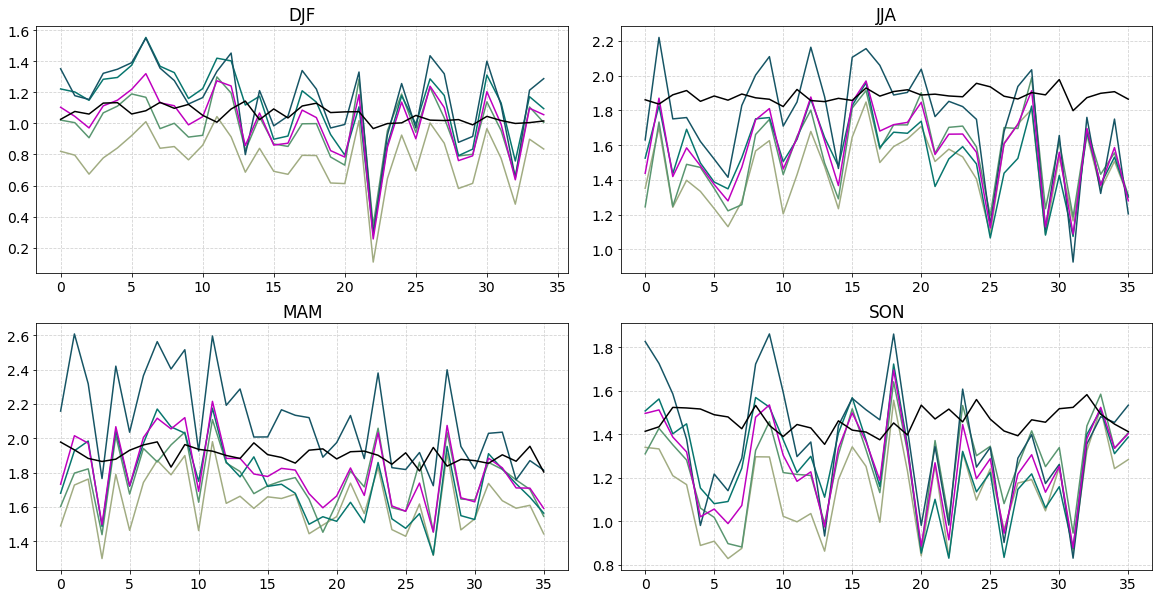

In [34]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (20,10))
gr = gs.GridSpec(2, 2, figure = fig, wspace = 0.1)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,1])]
for ax in axs:
    ax.grid(linestyle = '--', color = 'lightgrey')
axs[0].set_title('DJF')
axs[1].set_title('MAM')
axs[2].set_title('JJA')
axs[3].set_title('SON')
for k, clr in zip(keys, [cmocean.cm.rain(.3), cmocean.cm.rain(.45), cmocean.cm.rain(.62), cmocean.cm.rain(.76), 'm', 'k']):
    axs[0].plot(v_ave_DJF[k], color = clr)
    axs[1].plot(v_ave_MAM[k], color = clr)
    axs[2].plot(v_ave_JJA[k], color = clr)
    axs[3].plot(v_ave_SON[k], color = clr)
plt.savefig('../results/v6/vas-seasonal-timeseries.jpg', bbox_inches = 'tight')

# UAS trends

In [37]:
import scipy.stats as st

In [48]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(u_ave_DJF[k]['time'])), -u_ave_DJF[k]).slope)
    print(st.linregress(np.arange(0, len(u_ave_DJF[k]['time'])), -u_ave_DJF[k]).pvalue)

erai

-0.011714356647296795
0.2073388210197229
era5

-0.007395902614556449
0.401870797050656
cfsr

-0.019229410332332518
0.060593689817891795
jra55

-0.010368507637077301
0.24577219966556396
reanalysis

-0.012177044295029435
0.1815442588740928
cmip6

-0.010772414299639384
2.296451444561995e-05


In [49]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(u_ave_MAM[k]['time'])), -u_ave_MAM[k]).slope)
    print(st.linregress(np.arange(0, len(u_ave_MAM[k]['time'])), -u_ave_MAM[k]).pvalue)

erai

-0.0001494423572879337
0.9854157338292253
era5

0.0029495795485309662
0.6885921429870804
cfsr

-0.003946512685968786
0.6494244599818699
jra55

-0.008754445230829817
0.2025211677256815
reanalysis

-0.002475205177865107
0.7405345648571817
cmip6

-0.007596646893545202
0.001325542828654456


In [50]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(u_ave_JJA[k]['time'])), -u_ave_JJA[k]).slope)
    print(st.linregress(np.arange(0, len(u_ave_JJA[k]['time'])), -u_ave_JJA[k]).pvalue)

erai

0.006448618840098081
0.4368332036282111
era5

0.009448957189763053
0.22867274219239514
cfsr

0.007178860988209896
0.3068277742347331
jra55

-0.0059961182892395454
0.47682658001400235
reanalysis

0.004270079679890232
0.5758188430974021
cmip6

0.003193145937009014
0.05335208753158873


In [51]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(u_ave_SON[k]['time'])), -u_ave_SON[k]).slope)
    print(st.linregress(np.arange(0, len(u_ave_SON[k]['time'])), -u_ave_SON[k]).pvalue)

erai

0.01773852126299841
0.03361790792778882
era5

0.0194561079826098
0.011228006540839199
cfsr

0.010976400452990098
0.16642893140093926
jra55

0.005493868698287355
0.48914295755699055
reanalysis

0.013416224593304582
0.08151411258655683
cmip6

-0.0010935743812545836
0.617145641250977


# VAS trends

In [52]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(v_ave_DJF[k]['time'])), v_ave_DJF[k]).slope)
    print(st.linregress(np.arange(0, len(v_ave_DJF[k]['time'])), v_ave_DJF[k]).pvalue)

erai

-0.003380969553082454
0.2681059969485884
era5

-0.0036367402531588015
0.2636997598540982
cfsr

-0.010907037834797776
0.0055276910619379655
jra55

-0.008282926602849724
0.05174190840832958
reanalysis

-0.006551918554504222
0.06153140088749863
cmip6

-0.002782184328801783
0.0002164858362915362


In [53]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(v_ave_MAM[k]['time'])), v_ave_MAM[k]).slope)
    print(st.linregress(np.arange(0, len(v_ave_MAM[k]['time'])), v_ave_MAM[k]).pvalue)

erai

-0.003339144478019969
0.21790549135975235
era5

-0.003034443294349887
0.28633801173558215
cfsr

-0.009562321826620321
0.004548277770500822
jra55

-0.014290133689893651
0.00022643949169314992
reanalysis

-0.007556510832190993
0.012506028097031479
cmip6

-0.0017285249187004533
0.018398000387762608


In [54]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(v_ave_JJA[k]['time'])), v_ave_JJA[k]).slope)
    print(st.linregress(np.arange(0, len(v_ave_JJA[k]['time'])), v_ave_JJA[k]).pvalue)

erai

0.0022162214480453014
0.5147841583334013
era5

0.002698635610801157
0.4654611996887803
cfsr

-0.007042323191191418
0.03999274739809515
jra55

-0.010702864170807154
0.03231864670917911
reanalysis

-0.0032075825647112483
0.38757289703799225
cmip6

0.0008414680280154345
0.1405246294352486


In [55]:
for k in keys:
    print(k+'\n')
    print(st.linregress(np.arange(0, len(v_ave_SON[k]['time'])), v_ave_SON[k]).slope)
    print(st.linregress(np.arange(0, len(v_ave_SON[k]['time'])), v_ave_SON[k]).pvalue)

erai

0.003412692633725308
0.29073609413103424
era5

0.004252668317046011
0.19139889107815988
cfsr

-0.006177803772502704
0.08411016370656298
jra55

-0.0067370225232059235
0.12027581376444918
reanalysis

-0.0013123663441728056
0.6997632445243887
cmip6

0.0005674619896979438
0.5281675691489944
